In [182]:
import scanpy as sc
from scprocessing.Pipeline import Pipeline
from scprocessing.QC import QC
from scprocessing.Normalization import Normalization
from scprocessing.Integration import Integration
from scprocessing.metrics import jaccard, silhouette, davies, calinski, evaluate
from scprocessing.SelectPipeline import SelectPipeline

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# paths
nsg_bus_1 = "/mnt/shared/nationwide/Counts/NSG_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_bus_2 = "/mnt/shared/nationwide/Counts/NSG_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_bus_3 = "/mnt/shared/nationwide/Counts/NSG_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_CNTL_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_bus_1 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_2 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_bus_3 = "/mnt/shared/nationwide/Counts/NSG_S_BUS_3/outs/filtered_feature_bc_matrix.h5"

nsg_s_ctl_1 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_1/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_2 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_2/outs/filtered_feature_bc_matrix.h5"
nsg_s_ctl_3 = "/mnt/shared/nationwide/Counts/NSG_S_CNTL_3/outs/filtered_feature_bc_matrix.h5"

# Reading Datasets

In [3]:
# read data
nsg_bus_1_data = sc.read_10x_h5(nsg_bus_1)
nsg_bus_2_data = sc.read_10x_h5(nsg_bus_2)
nsg_bus_3_data = sc.read_10x_h5(nsg_bus_3)

# creating metadata
nsg_bus_1_data.obs["Trial"] = "1"
nsg_bus_2_data.obs["Trial"] = "2"
nsg_bus_3_data.obs["Trial"] = "3"

# making names unique
nsg_bus_1_data.var_names_make_unique()
nsg_bus_2_data.var_names_make_unique()
nsg_bus_3_data.var_names_make_unique()

nsg_bus_1_data.obs_names_make_unique()
nsg_bus_2_data.obs_names_make_unique()
nsg_bus_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [4]:
nsg_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_ctl_1_data.obs["Trial"] = "1"
nsg_ctl_2_data.obs["Trial"] = "2"
nsg_ctl_3_data.obs["Trial"] = "3"

nsg_ctl_1_data.var_names_make_unique()
nsg_ctl_2_data.var_names_make_unique()
nsg_ctl_3_data.var_names_make_unique()

nsg_ctl_1_data.obs_names_make_unique()
nsg_ctl_2_data.obs_names_make_unique()
nsg_ctl_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [5]:
nsg_s_bus_1_data = sc.read_10x_h5(nsg_s_bus_1)
nsg_s_bus_2_data = sc.read_10x_h5(nsg_s_bus_2)
nsg_s_bus_3_data = sc.read_10x_h5(nsg_s_bus_3)

nsg_s_bus_1_data.obs["Trial"] = "1"
nsg_s_bus_2_data.obs["Trial"] = "2"
nsg_s_bus_3_data.obs["Trial"] = "3"

nsg_s_bus_1_data.var_names_make_unique()
nsg_s_bus_2_data.var_names_make_unique()
nsg_s_bus_3_data.var_names_make_unique()

nsg_s_bus_1_data.obs_names_make_unique()
nsg_s_bus_2_data.obs_names_make_unique()
nsg_s_bus_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

In [6]:
nsg_s_ctl_1_data = sc.read_10x_h5(nsg_ctl_1)
nsg_s_ctl_2_data = sc.read_10x_h5(nsg_ctl_2)
nsg_s_ctl_3_data = sc.read_10x_h5(nsg_ctl_3)

nsg_s_ctl_1_data.obs["Trial"] = "1"
nsg_s_ctl_2_data.obs["Trial"] = "2"
nsg_s_ctl_3_data.obs["Trial"] = "3"

nsg_s_ctl_1_data.var_names_make_unique()
nsg_s_ctl_2_data.var_names_make_unique()
nsg_s_ctl_3_data.var_names_make_unique()

nsg_s_ctl_1_data.obs_names_make_unique()
nsg_s_ctl_2_data.obs_names_make_unique()
nsg_s_ctl_3_data.obs_names_make_unique()

/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: Use

# Run Pipeline

In [132]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization(method="zheng17"))
preprocess.add_step(Integration(method="merge"))

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


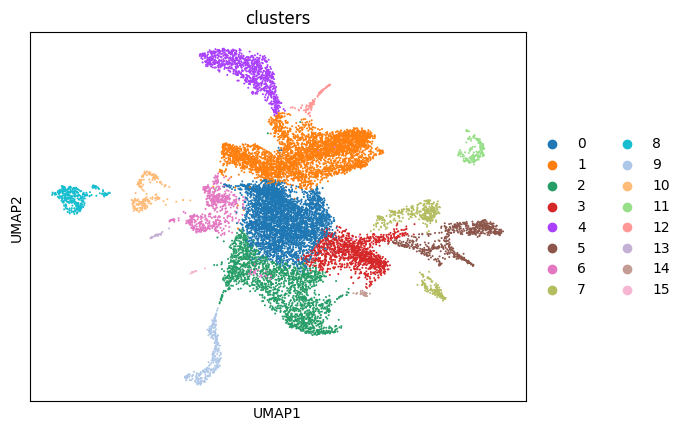

In [33]:
integrated = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
2024-05-09 16:10:04,943 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-09 16:10:13,916 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-09 16:10:13,987 - harmonypy - INFO - Iteration 1 of 10
2024-05-09 16:10:16,332 - harmonypy - INFO - Iteration 2 of 10
2024-05-09 16:10:18,697 - harmonypy - INFO - Converged after 2 iterations


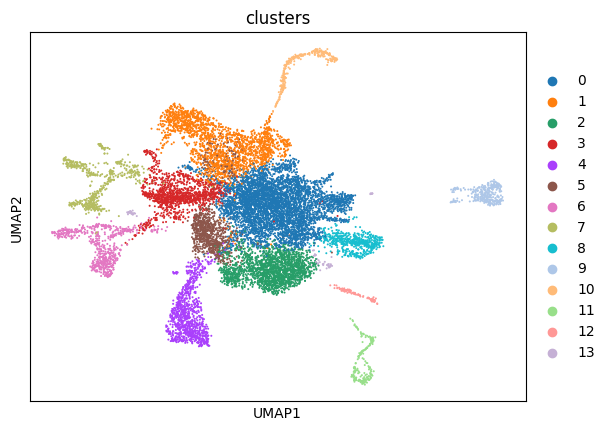

In [134]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization(method="seurat"))
preprocess.add_step(Integration(method="harmony"))
harmony = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

In [ ]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization(method="seurat"))
preprocess.add_step(Integration(method="merge"))
sctransform = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Processing datasets 1 <=> 2
Processing datasets 2 <=> 3
Processing datasets 1 <=> 3


/home/user/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


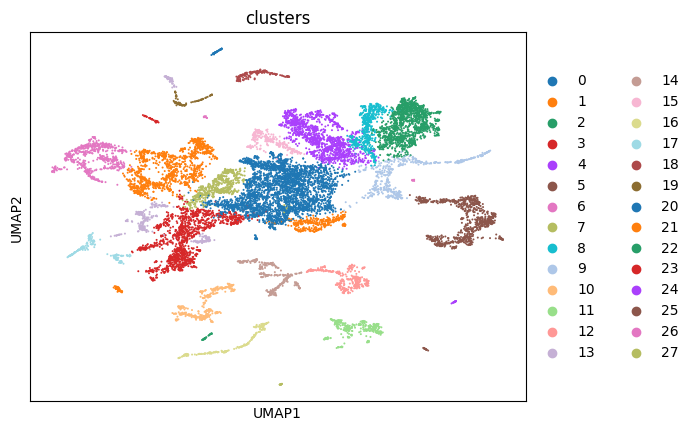

In [39]:
preprocess = Pipeline()
preprocess.add_step(QC())
preprocess.add_step(Normalization())
preprocess.add_step(Integration(method="scanorama"))
scanorama = preprocess.execute([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])

# Metrics

In [140]:
evaluate(integrated, key="clusters")

jaccard
silhouette
davies
calinski


[0.9991045817102163, 0.027899614, 2.713938509225196, 473.7523519729654]

In [141]:
evaluate(harmony, "clusters")

jaccard
silhouette
davies
calinski


[0.9947450334722553, -0.003565091, 2.415982333596569, 849.2674682905991]

# Model Selection

In [186]:
select.metrics + ["rimtio,"]

['jaccard, silhouette', 'davies', 'calinski', 'rimtio,']

Quality Control
Normalizing Datasets
Integrating Datasets


/home/user/.conda/envs/python3.8/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


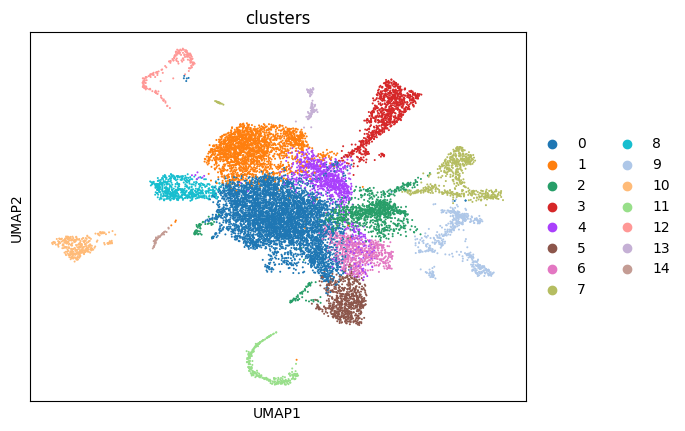

jaccard, silhouette
davies
calinski


/home/user/scRNAseq-benchmarking/scprocessing/metrics.py:89: UserWarning: Invalid Metric: jaccard, silhouette
  warnings.warn(f"Invalid Metric: {m}")


ValueError: Length mismatch: Expected axis has 3 elements, new values have 4 elements

In [183]:
select = SelectPipeline(normalization=["seurat"], integration=["merge"])
select.search([nsg_s_ctl_1_data, nsg_s_ctl_2_data, nsg_s_ctl_3_data])